<a href="https://colab.research.google.com/github/RudyMartin/yelp/blob/main/YelpReviews_2_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Rudy Martin <realrudymartin@gmail.com> (2025-01-07)

# Analyzing Yelp Reviews with Embeddings, Clustering, and Summarization

Welcome! In this notebook, we'll explore how to analyze customer reviews for a set of Yelp Reviews. We'll use embeddings, clustering, and summarization techniques to understand the key themes and customer sentiment within the reviews.

Our goal is to determine whether Yelp review themes have shifted pre vs. post March 2020 (pre vs. post pandemic), or noticeably over other stretches of time.

Let's get started!




## Login to Google Colab at https://colab.research.google.com

This assumes you have working API keys for at least one chatAPI. In this case OpenAi and Google Gemini. Also we will create a separate folder called "yelp" on our drive to work from.

In [ ]:
# [1] Import necessary libraries

# Add directory to the system's path
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import google.generativeai as genai
import os
import sys
from datetime import datetime
from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# [2] API configuration and system path setup. - place in secrets later
sys.path.append('/content/drive/My Drive/yelp/')
OPENAI_API_KEY= "sk-xx"
GEMINI_API_KEY="xx"
openai.api_key = OPENAI_API_KEY
genai.configure(api_key=GEMINI_API_KEY)

## Load the dataset
The dataset is from Kaggle: https://www.kaggle.com/datasets/farukalam/yelp/restaurant-reviews/data

You'll need to download it and place it in the same directory as this notebook or provide the correct path below.

For simplicity, I assume you have renamed the dataset CSV to 'Yelp Restaurant Reviews.csv'

In [ ]:
# [3] Data Loading
drive.mount("/content/drive", force_remount=True)
data_dir = '/content/drive/My Drive/yelp/'
data_path = f'{data_dir}Yelp Restaurant Reviews.csv'
try:
    data = pd.read_csv(data_path)
    print("Dataset loaded successfully. Columns:", data.columns)
except FileNotFoundError:
    print("Error: Dataset not found. Please check the path.")

# [4] Data Preprocessing
data['Date'] = pd.to_datetime(data['Date'])

# for cost/time reasons just focus on the two years before and the year after March 2020 (see ratings history notebook for details)
data = data[(data['Date'] >= '2018-03-01') & (data['Date'] <= '2022-02-28')]  # Limiting data around March 2020

data['Year'], data['Month'] = data['Date'].dt.year, data['Date'].dt.month
data['Pre_March_2020'] = data['Date'] < datetime(2020, 3, 1)
data['Polarity'] = data['Review Text'].apply(lambda text: TextBlob(text).sentiment.polarity)
data['Sentiment'] = data['Polarity'].apply(lambda x: 'Positive' if x > 0.1 else 'Negative' if x < -0.1 else 'Neutral')

full_data = data.copy()
# always savve full data for recovery from errors
full_data.to_csv(f'{data_dir}df_all_reviews.csv', index=False)


Mounted at /content/drive
Dataset loaded successfully. Columns: Index(['Yelp URL', 'Rating', 'Date', 'Review Text'], dtype='object')


## Create Embeddings

In [ ]:
# [5] Text Embedding and Clustering
# can break since dif embedding engines
def embed_text(text, model_name="text-embedding-ada-002", max_retries=3):
    """
    Embeds a given text using ChatGPT (preferred) or Gemini (fallback).

    Args:
        text (str): The text to embed.
        model_name (str, optional): The ChatGPT embedding model to use.
                                   Defaults to "text-embedding-ada-002".
        max_retries (int, optional): Maximum number of retries for ChatGPT API. Defaults to 3.

    Returns:
        list or None: The embedding as a list of floats, or None if both models fail.
    """
    retries = 0
    while retries < max_retries:
      try:
          # ChatGPT Embedding (Updated for openai>=1.0.0)
          response = openai.embeddings.create(
             input=[text],
             model=model_name
          )
          return response.data[0].embedding
      except (openai.APIError, Exception) as e:
        print(f"ChatGPT API error ({retries+1}/{max_retries}): {e}")
        retries += 1
        time.sleep(2**retries) #Exponential backoff to not overload the API

    print("ChatGPT embedding failed. Falling back to Gemini.")

    try:
        # Gemini Embedding (Fallback)
        model = genai.GenerativeModel('models/embedding-001')
        response = model.embed_content(content=text)
        return response.embedding # return the embedding
    except Exception as e:
        print(f"Gemini API error: {e}")
        print("Both ChatGPT and Gemini embedding failed.")
        return None

 # Apply the embedding function, using Review Text as the column
if 'Review Text' in data.columns:
   data['embedding'] = data['Review Text'].apply(embed_text)
else:
  print("Error: No column named 'Review Text' in the dataframe, please rename your text column to 'Review Text'")

# Add a boolean column called 'failed' indicating if there was a failed embed
data['failed'] = data['embedding'].apply(lambda x: x is None)

# Remove rows where embedding transformation failed
data.dropna(subset=['embedding'], inplace=True)

# Stack the embeddings to form a matrix.
if not data.empty:
    embeddings = np.stack(data['embedding'].to_numpy())
    print("Shape of embedding matrix:", embeddings.shape)
    # Create a DataFrame
    df_embed = pd.DataFrame(embeddings)
    # Save to CSV
    df_embed.to_csv(f'{data_dir}embeddings_107.csv', index=False)
else:
    print("DataFrame is empty after removing rows with failed embeddings")
print(data)

Shape of embedding matrix: (8683, 1536)
                                                Yelp URL  Rating       Date  \
0      https://www.yelp.com/biz/sidney-dairy-barn-sidney       5 2022-01-22   
2      https://www.yelp.com/biz/sidney-dairy-barn-sidney       5 2021-08-07   
5      https://www.yelp.com/biz/sidney-dairy-barn-sidney       5 2019-05-01   
9      https://www.yelp.com/biz/sidney-dairy-barn-sidney       2 2019-07-26   
11     https://www.yelp.com/biz/sidney-dairy-barn-sidney       5 2018-05-18   
...                                                  ...     ...        ...   
19891  https://www.yelp.com/biz/la-pasticceria-las-vegas       4 2021-07-17   
19892  https://www.yelp.com/biz/la-pasticceria-las-vegas       4 2019-10-21   
19893  https://www.yelp.com/biz/la-pasticceria-las-vegas       4 2019-10-12   
19894  https://www.yelp.com/biz/la-pasticceria-las-vegas       5 2021-04-11   
19895  https://www.yelp.com/biz/la-pasticceria-las-vegas       4 2019-09-03   

           

Clustering reveals common themes and sentiments shared between reviews. The "optimal" number of clusters might represent the key areas in which customers discuss their experience with a business: e.g., "food quality," "service speed," or "atmosphere". The business can then focus their improvements and efforts on the pain points.

In [ ]:
# Check and clean the 'embedding' column before applying the conversion
data['embedding'] = data['embedding'].astype(str)  # Ensure all entries are strin

## Clustering Exploration

Now, we will explore different numbers of clusters to find the optimal number using the elbow method and silhouette score.

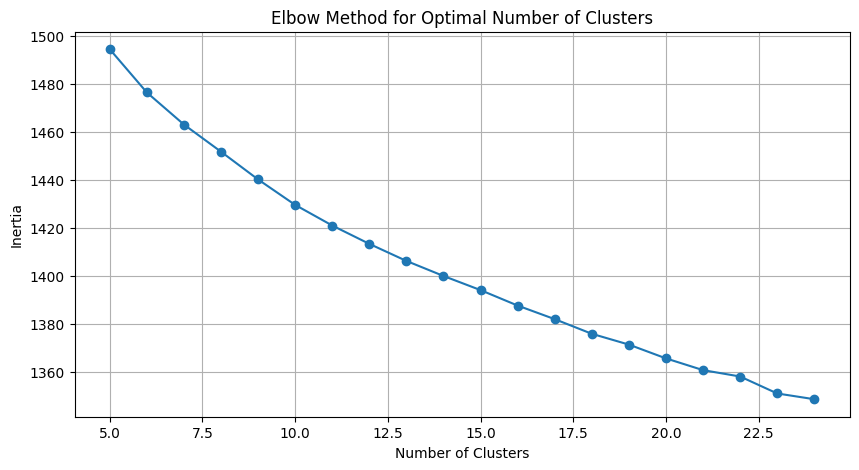

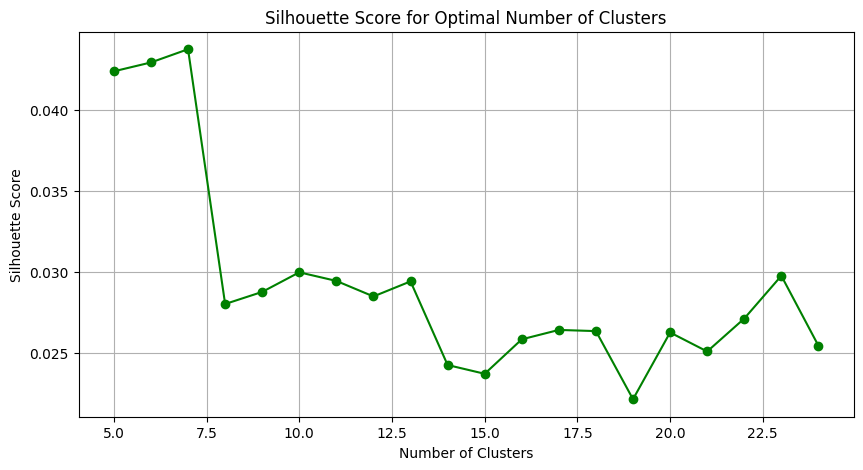

In [ ]:
# Define function to evaluate clustering
def evaluate_clusters(embeddings, cluster_range):
  inertia_scores = []
  silhouette_scores = []

  for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
    kmeans.fit(embeddings)
    inertia_scores.append(kmeans.inertia_)

    # Avoid silhouette score for n_clusters = 1 and n_samples less than 2
    if n_clusters > 1 and embeddings.shape[0] > 1:
        silhouette = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(silhouette)
    else:
        silhouette_scores.append(np.nan) # Indicate that silhouette score not calculated


  return inertia_scores, silhouette_scores

# Test different number of clusters (3 to 12)
cluster_range = range(5, 25)
inertia_scores, silhouette_scores = evaluate_clusters(embeddings, cluster_range)

# Plot the Elbow method graph for Inertia
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_scores, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plot the Silhouette Score graph
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Based on these plots, it looks like 15 might be a suitable number of clusters since it gives a downward bend in the elbow plot, and seems fall on silhouette score before rising again.

## Clustering Implementation


We can use similar summarization techniques to understand the dominant opinions and concerns within each cluster of Yelp reviews. This gives us a concise and actionable way to understand what's driving the sentiment in each topic.

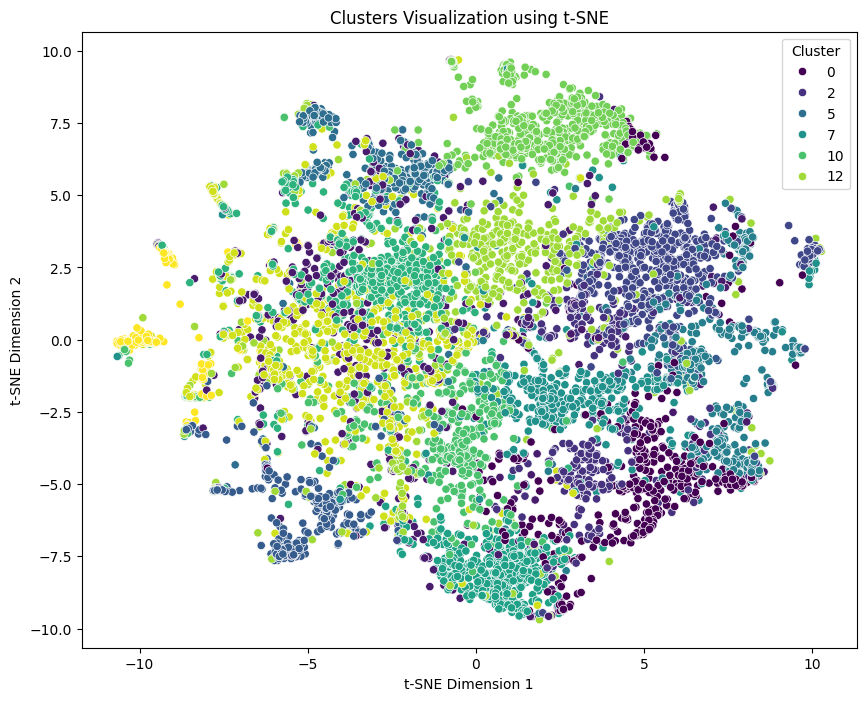

In [ ]:
# Define the optimal number of clusters based on the plots
optimal_clusters = 15

# Apply k-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42, n_init=10)
kmeans.fit(embeddings)

# Add cluster labels to our DataFrame
data['cluster'] = kmeans.labels_

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot clusters using t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=data['cluster'], palette='viridis')
plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# low quality seperation. let's try lower clusters

# Calculate silhouette score for the clustered data.
silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Inertia
inertia_value = kmeans.inertia_
print(f"Inertia: {inertia_value:.2f}")


# Calinski-Harabasz index.
calinski_harabasz_index = calinski_harabasz_score(embeddings, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz_index:.2f}")

# Davies-Bouldin index
davies_bouldin_index = davies_bouldin_score(embeddings, kmeans.labels_)
print(f"Davies-Bouldin Index: {davies_bouldin_index:.2f}")

Silhouette Score: 0.02
Inertia: 1394.18
Calinski-Harabasz Index: 118.79
Davies-Bouldin Index: 4.46


Let's try fewer clusters see if we get clearer separation between groups.

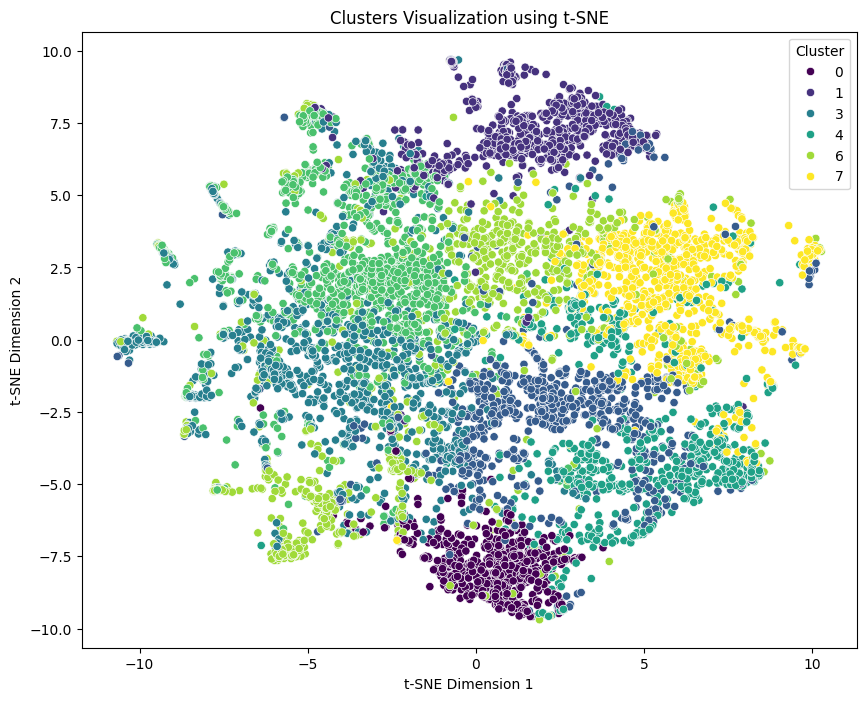

In [ ]:
# Define the optimal number of clusters based on the plots
optimal_clusters = 8

# Apply k-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(embeddings)

# Add cluster labels to our DataFrame
data['cluster'] = kmeans.labels_

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot clusters using t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=data['cluster'], palette='viridis')
plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()


## Cluster Interpretation

Now, let's use an AI model to summarize the main themes of each cluster. We'll use OpenAI's GPT-4 API for this.
**Important:** Make sure to have your OpenAI API key configured as an environment variable or set it directly before running the next cells.


In [ ]:
# OpenAI API Key
# Ensure you have an API key for OpenAI. Set it here or as an environment variable.

# To enable, you need to set OPENAI_API_KEY environment variable with your key
# import os
# openai.api_key = os.environ.get("OPENAI_API_KEY")

OPENAI_API_KEY= "sk-xx"

openai.api_key = OPENAI_API_KEY

import openai
from openai import OpenAI

def summarize_cluster(reviews, cluster_label):
  """Summarizes the main themes and trends within the given reviews using the OpenAI model."""

  if not openai.api_key:
    print("Error: OpenAI API key is not set. Please set the 'openai.api_key' or ensure the 'OPENAI_API_KEY' environment variable is set.")
    return None

  prompt = f"""Digest the main themes and trends of the following reviews of restaurants and food delivery services. Focus on what makes this cluster distinct. Provide a suggested cluster label:\n{reviews[:1000]}"""

  try:
      client = OpenAI(api_key=openai.api_key)
      response = client.chat.completions.create(
          model="gpt-4",  # or "gpt-3.5-turbo" for faster/cheaper results
          messages=[
              {"role": "system", "content": "You are a helpful assistant."},
              {"role": "user", "content": prompt},
          ]
      )
      return response.choices[0].message.content.strip()

  except AttributeError:
      print("Error: The openai.ChatCompletion interface is no longer supported in openai>=1.0.0. Please update your code to the latest API interface.")
      return None
  except Exception as e:
      print(f"An error occurred during API call: {e}")
      return None

# Summarize each cluster using the OpenAI model
cluster_summaries = {}
for cluster_label in range(optimal_clusters):
    cluster_reviews = data[data['cluster'] == cluster_label]['Review Text'].tolist()
    reviews_str = "\n".join(cluster_reviews[:25]) # limit number of reviews to not overload context window
    summary = summarize_cluster(reviews_str, cluster_label)

    if summary:
      cluster_summaries[cluster_label] = summary
      print(f"Cluster {cluster_label} Summary:")
      print(summary)
      print("-" * 50)
    else:
      print(f"Skipping Cluster {cluster_label} Summary due to error.")
      print("-" * 50)


Cluster 0 Summary:
The cluster focuses on reviews of food services/ restaurants that have unique, innovative, and fun concepts like mixing cereal and ice cream. There's a theme of these establishments being highly Instagrammable due to their creative aesthetics. The reviews indicate a trend for trying out novel food concoctions and the experience doesn't necessarily have to impress as much as the novelty itself should be interesting. 

Suggested Cluster Label: Novelty Dessert Experiences
--------------------------------------------------
Cluster 1 Summary:
Main Themes and Trends:

1. The reviews mostly talk about specialised dessert or bakery-based stores which are specifically famous for their sweet treats like donuts, pastries, and cannolis.
2. These establishments not only offer unique and authentic flavors (like matcha cream, creme brulee, egg nog, and lavender lemon) in their offerings but also a pleasant overall store atmosphere.
3. They have a dedicated niche of customers willin

## Cluster Quality Evaluation

Finally, we'll evaluate the quality of our clusters using various metrics.

In [ ]:


# Calculate silhouette score for the clustered data.
silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Inertia
inertia_value = kmeans.inertia_
print(f"Inertia: {inertia_value:.2f}")


# Calinski-Harabasz index.
calinski_harabasz_index = calinski_harabasz_score(embeddings, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz_index:.2f}")

# Davies-Bouldin index
davies_bouldin_index = davies_bouldin_score(embeddings, kmeans.labels_)
print(f"Davies-Bouldin Index: {davies_bouldin_index:.2f}")


Silhouette Score: 0.03
Inertia: 1451.72
Calinski-Harabasz Index: 179.23
Davies-Bouldin Index: 4.61


Each metric gives insight into different aspects of the cluster's characteristics:

Silhouette Score (0.03):

  This score ranges from -1 to +1. A high silhouette score close to +1 indicates that clusters are well separated and cohesive, meaning data points within the same cluster are similar to each other and different from points in other clusters.
  A score of 0.03 suggests that clusters are overlapping significantly with no clear distinction between them. This indicates that the clustering might not be very meaningful or useful.

Inertia (1451.72):

  Inertia, also known as within-cluster sum of squares, measures the total distance of each point to its respective centroid. A lower inertia value indicates a better model, as it suggests that clusters are compact and well-defined.
  An inertia of 1451.72 can be hard to interpret without context (like total number of points, dimensions, and range of data), but generally, you want this number to be as low as possible for good clustering.

Calinski-Harabasz Index (179.23):

  This index is a measure of cluster validity based on the ratio of the sum of between-clusters dispersion and of within-cluster dispersion. Higher values generally mean better defined clusters.
  A score of 179.23 can be considered moderate, suggesting some degree of separation between clusters, but it's not particularly high, indicating that while there is some structure, it might not be very strong.

Davies-Bouldin Index (4.61):

  The Davies-Bouldin index measures the average similarity between clusters, where similarity is the ratio of within-cluster distances to between-cluster distances. Lower values indicate better clustering, with a value of 0 being the ideal.
  A score of 4.61 is relatively high, which indicates poor clustering quality. This suggests that the clusters are not well-separated and/or that there is considerable variance within clusters.



## Overall Interpretation: These scores collectively suggest that the clustering performed may not be very effective.

Possible issues:

* Pre and post data combined - expect clearer reads
* All ratings included. Top ratings more indicative of actionable positive steps for business.
* Negative sentiment, though smaller in counts may indicate possible issues for specific businesses/regions. Out of scope.

Next steps:

* Try more structured labeling approaches to pull apart noisy data.